In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

In [21]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 15
page_size = 100

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 100 total reviews
Scraping page 2
   ---> 200 total reviews
Scraping page 3
   ---> 300 total reviews
Scraping page 4
   ---> 400 total reviews
Scraping page 5
   ---> 500 total reviews
Scraping page 6
   ---> 600 total reviews
Scraping page 7
   ---> 700 total reviews
Scraping page 8
   ---> 800 total reviews
Scraping page 9
   ---> 900 total reviews
Scraping page 10
   ---> 1000 total reviews
Scraping page 11
   ---> 1100 total reviews
Scraping page 12
   ---> 1200 total reviews
Scraping page 13
   ---> 1300 total reviews
Scraping page 14
   ---> 1400 total reviews
Scraping page 15
   ---> 1500 total reviews


In [22]:
df = pd.DataFrame()
df["reviews"] = reviews
df.head()

,reviews
0,"Not Verified | Boarded on time, but it took a..."
1,"✅ Trip Verified | 5 days before the flight, w..."
2,Not Verified | \r\nWe traveled to Lisbon for ...
3,✅ Trip Verified | Booked a flight from Buchar...
4,✅ Trip Verified | Booked online months ago an...


In [24]:
df[['Verified','Reviews']]=df['reviews'].str.split('|', expand=True)

In [25]:
df.drop(columns=['reviews'], inplace=True)

In [26]:
df.to_csv("C:/Users/dell/Downloads/data/BA_reviews.csv")

In [2]:
data=pd.read_csv("C:/Users/dell/Downloads/data/BA_reviews.csv", index_col=0)
data['id']=data.index

In [3]:
idd=data.pop('id')
data.insert(0, 'Id',idd)

In [4]:
data['Verified'].value_counts()

✅ Trip Verified                                                                                                                                                                                                                                                                                                                                                                                                                                                      1151
Not Verified                                                                                                                                                                                                                                                                                                                                                                                                                                                          229
✅ Verified Review                                                                   

In [5]:
data.dropna(inplace=True)

In [6]:
data.head()

,Id,Verified,Reviews
0,0,Not Verified,"Boarded on time, but it took ages to get to ..."
1,1,✅ Trip Verified,"5 days before the flight, we were advised by..."
2,2,Not Verified,\r\nWe traveled to Lisbon for our dream vaca...
3,3,✅ Trip Verified,Booked a flight from Bucharest to Manchester...
4,4,✅ Trip Verified,Booked online months ago and the only hitch ...


In [7]:
data['Reviews']=data['Reviews'].str.lower()

In [8]:
import string
print(string.punctuation)

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [9]:
def remove_punctuation(input_string):
    # Make a translation table that maps all punctuation characters to None
    translator = str.maketrans("", "", string.punctuation)

    # Apply the translation table to the input string
    result = input_string.translate(translator)

    return result

data['reviews']=data['Reviews'].apply(remove_punctuation)

In [10]:
stop_words=["i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours", "yourself",
              "yourselves", "he", "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself",
              "they", "them", "their", "theirs", "themselves", "what", "which", "who", "whom", "this", "that", "these",
              "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had", "having", "do",
              "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while",
              "of", "at", "by", "for", "with", "about", "against", "between", "into", "through", "during", "before",
              "after", "above", "below", "to", "from", "up", "down", "in", "out", "on", "off", "over", "under", "again",
              "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any", "both", "each",
              "few", "more", "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so", "than",
              "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"]


In [11]:
tokenized=data['reviews'].str.split()

In [13]:
final_words=[]
for word in tokenized:
    if word not in stop_words:
        final_words.append(word)

In [15]:
#from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.sentiment import SentimentAnalyzer
import nltk
from tqdm.notebook import tqdm
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

res = {}
for i, row in tqdm(data.iterrows(),total=len(data)):
    text = row['reviews']
    myid = row['Id']
    res[myid] = sia.polarity_scores(text)


In [17]:
si=pd.DataFrame(res).T
si=si.reset_index().rename(columns={'index':'Id'})
data=data.merge(si, on='Id')

In [32]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification
from scipy.special import softmax
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)


# Define a function to predict sentiment
def predict_sentiment(sentence):
    encoded_text = tokenizer(sentence, truncation=True, padding='max_length', max_length=512, return_tensors='pt')
    output = model(**encoded_text)
    scores = output[0][0].detach().numpy()
    scores = softmax(scores)
    scores_dict = {
    'roberta_neg' : scores[0],
    'roberta_neu' : scores[1],
    'roberta_pos' : scores[2]
    }
    return scores_dict
    #return scores.index(max(scores))

# Predict the sentiment of each sentence in the dataset
#sentiments = []
#for sentence in data["reviews"]:
 #   sentiment = predict_sentiment(sentence)
  #  sentiments.append(sentiment)
    
rev={}
for i, row in tqdm(data.iterrows(), total=len(data)):
    text=row['reviews']
    myid=row['Id']
    rev[myid]=predict_sentiment(text)


# Add the sentiment labels to the dataset
#data["sentiment"] = sentiments

# Print the sentiment labels
#print(data["sentiment"].value_counts())


  0%|          | 0/1499 [00:00<?, ?it/s]

In [34]:
si=pd.DataFrame(rev).T
si=si.reset_index().rename(columns={'index':'Id'})
df=data.merge(si, on='Id')

In [42]:
df.rename(columns={'roberta_neg':'negative','roberta_pos':'positive','roberta_neu':'neutral'}, inplace=True)

In [43]:
df.head(1)

,Id,Verified,Reviews,reviews,neg,neu,pos,compound,negative,neutral,positive,reviews_column
0,0,Not Verified,"boarded on time, but it took ages to get to ...",boarded on time but it took ages to get to t...,0.0,0.931,0.069,0.5927,0.018204,0.172404,0.809392,roberta_pos


In [44]:
def highest_column(row):
    return row.idxmax()

# Create a new column with the column name of the highest value
df['reviews_sentiment'] = df[['negative', 'neutral', 'positive']].apply(highest_column, axis=1)



In [46]:
df.drop(columns=['reviews_column'], inplace=True)

In [50]:
negative_reviews=df[df['reviews_sentiment']=='negative']

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
# Preprocess the text
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

negative_words=[]

for review in negative_reviews['Reviews']:
    words = review.split()
    for word in words:
        if word not in stop_words and len(word) > 2:
            negative_words.append(lemmatizer.lemmatize(word))

from collections import Counter
word_counts = Counter(negative_words)
leading_reasons = word_counts.most_common(10)

print(leading_reasons)

[('flight', 1551), ('seat', 670), ('service', 534), ('hour', 489), ('british', 444), ('one', 429), ('london', 429), ('get', 419), ('would', 380), ('staff', 370)]


In [71]:
reasons=pd.DataFrame(leading_reasons).T

In [74]:
reasons.columns=reasons.iloc[0]

In [76]:
reasons=reasons.drop(0)

In [77]:
reasons

,flight,seat,service,hour,british,one,london,get,would,staff
1,1551,670,534,489,444,429,429,419,380,370


<Axes: xlabel='0'>

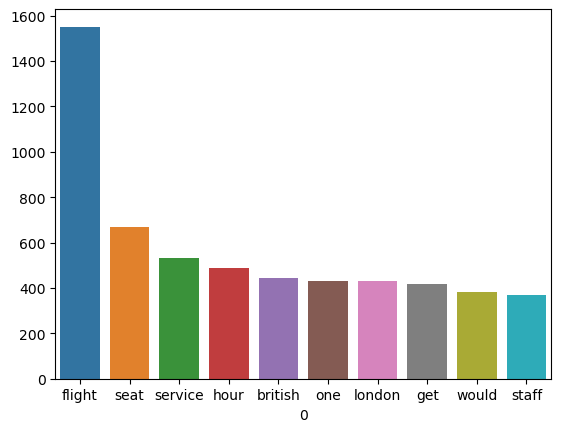

In [86]:
import seaborn as sns
sns.barplot(reasons)

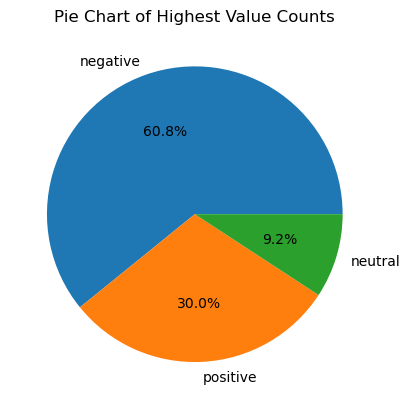

In [47]:
import matplotlib.pyplot as plt
reviews_counts = df['reviews_sentiment'].value_counts()
plt.pie(reviews_counts, labels=reviews_counts.index, autopct="%1.1f%%")
plt.title("Pie Chart of Highest Value Counts")
plt.show()

<BarContainer object of 3 artists>

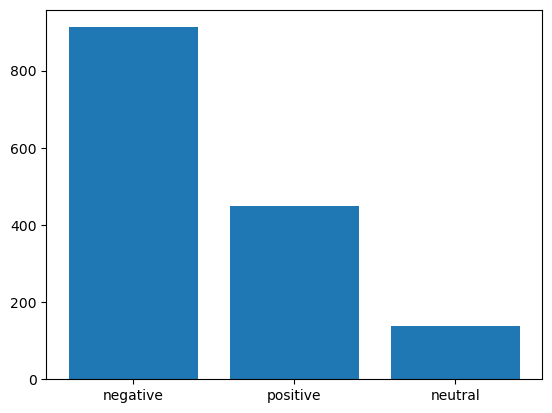

In [48]:
plt.bar(reviews_counts.index, reviews_counts.values)

In [54]:
pip install h5py

Note: you may need to restart the kernel to use updated packages.
